In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from pandas.core.common import flatten

import muwclass
from muwclass import datasets, prep, red,  classify, distribution, mcmc, plots, prepare_data
from muwclass import class_names,class_colors, exnum,n_classes,class_labels,CSC_features,X_features,MW_features,colors_all,var_features

#import os
#import glob
#import pandas as pd

from sklearn.metrics import confusion_matrix
from math import ceil, floor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, balanced_accuracy_score
from numpy import interp


import warnings
warnings.filterwarnings('ignore')

In [2]:
figs1, figs2 = 7, 6
texts = 10
def plot_CM_withSTD(cm, tds, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    #cm = confusion_matrix(y_true, y_pred)
    total = np.sum(cm, axis=1)
    class_with_num = [classes[i] +'\n'+ str(round(total[i])) for i in range(len(total))]
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm_copy = cm.copy()
        cm = cm.astype('float') / cm_copy.sum(axis=1)[:, np.newaxis]
        tds = tds.astype('float') / cm_copy.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(tds)
    
    fig, ax = plt.subplots(figsize=(figs1, figs2))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[clas for clas in classes], yticklabels=class_with_num,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
        
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
           
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #print(thresh)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, "{:.2f} \n".format(cm[i,j])+r"$\pm$"+"{:.2f}".format(tds[i,j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",fontsize=texts)
    fig.tight_layout()
    return fig




def plot_newROC(y_test,y_pred, probs,classes):    
    # Compute ROC curve and ROC area for each class
    
    
    y_test_bin = label_binarize(y_test, classes=classes)  
    y_pred_bin = label_binarize(y_pred, classes=classes)  
    fpr_i, tpr_i, thres_i, fpr, tpr, thres, roc_auc = dict(), dict(), dict(), dict(), dict(), dict(), dict()
    
    for i in range(n_classes):
        #print(i)
        
        fpr_i[i], tpr_i[i], thres_i[i] = roc_curve(y_test_bin[:, i], probs[:, i])
        ind_p = np.where(y_pred_bin[:, i]==1)[0]
        probs_min = min(probs[:,i][ind_p])
        #print(probs_min)
        ind_fil = np.where((thres_i[i]>=probs_min) | (thres_i[i]==0))[0]
        fpr[i], tpr[i], thres[i] = fpr_i[i][ind_fil], tpr_i[i][ind_fil], thres_i[i][ind_fil]
        
        roc_auc[i] = auc(fpr[i], tpr[i])
        

    lw = 2
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure(figsize=(figs1, figs2))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), class_colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right",fontsize=texts)
    
    return fig   


def plot_oldROC(y_test,y_pred, probs,classes):    
    # Compute ROC curve and ROC area for each class
    
    y_test_bin = label_binarize(y_test, classes=classes)  
    y_pred_bin = label_binarize(y_pred, classes=classes)  
    fpr_i, tpr_i, thres_i, fpr, tpr, thres, roc_auc = dict(), dict(), dict(), dict(), dict(), dict(), dict()
    
    for i in range(n_classes):
        #print(i)
        
        #fpr_i[i], tpr_i[i], thres_i[i] = roc_curve(y_test_bin[:, i], probs[:, i])
        #ind_p = np.where(y_pred_bin[:, i]==1)[0]
        #probs_min = min(probs[:,i][ind_p])
        #print(probs_min)
        #ind_fil = np.where((thres_i[i]>=probs_min) | (thres_i[i]==0))[0]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])#fpr_i[i][ind_fil], tpr_i[i][ind_fil], thres_i[i][ind_fil]
        
        roc_auc[i] = auc(fpr[i], tpr[i])
        

    lw = 2
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure(figsize=(figs1, figs2))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), class_colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return fig   



#imps = np.array(imps).T * 100





def plot_multi_Feature_Importance(imps,features):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(features)
    imps_cum = imps.cumsum(axis=1)
    print(imps_cum)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, imps.shape[1]))

    fig, ax = plt.subplots(figsize=(figs1, figs2))
    ax.invert_yaxis()
    #ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(imps, axis=1).max())

    for i, color in enumerate(category_colors):
        widths = imps[:, i]
        starts = imps_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.9,
                 color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    #ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              #loc='lower left', fontsize='small')
    ax.set_xlabel('Importance (in % usage)',fontweight='bold',fontsize=20)
    ax.set_xticks(np.array([0,2,4,6,8,10,12,14,16,18])*len(imps.T))
    ax.set_xticklabels(([0,2,4,6,8,10,12,14,16,18]),fontweight='bold',fontsize=12)
    #ax.set_xticklabels(('0','2','4','6','8','10','12','14','16','18'),fontweight='bold',fontsize=12)
    ax.set_title('Feature Importance',fontweight='bold',fontsize=20)
    ax.set_yticklabels(features,fontweight='bold',fontsize=15)

    return fig, ax

def plot_Feature_Importance_withSTD_withnoran(imp, std, imp_noran, std_noran, features):
    #sbn.set_style("white")
    N = len(imp)

    ind = np.arange(N)  # the x locations for the groups
    
    width = 0.7#16./N *2.      # the width of the bars

    fig, ax = plt.subplots(figsize=(figs1, figs2))
    rects1 = ax.barh(ind, imp*100, width, xerr=std*100, ecolor='orange')
    rects2 = ax.barh(ind, imp_noran*100, width, xerr=std_noran*100, alpha=0, ecolor='red')
    #rects2 = ax.bar(ind + width, lassoo*100, width, color='g')
    # add some text for labels, title and axes ticks
    ax.set_xlabel('Importance (in % usage)',fontweight='bold',fontsize=20)
    ax.set_xticklabels(('0','2','4','6','8','10','12','14','16','18'),fontweight='bold',fontsize=12)
    ax.set_title('Feature Importance',fontweight='bold',fontsize=20)
    ax.set_yticks(ind)
    ax.set_yticklabels(features,fontweight='bold',fontsize=15)

    #ax.legend(rects1[0], ('Random Forest Regressor'))
    ax.set_xlim(0,16)
    ax.set_ylim(-0.5,N+0.5)
    

    print('There are ',len(features), ' features')
    print(features)
    for threshold, color in zip([0.8,1., 1.5], ['orange','red','green']):
        thres = threshold/100
    
        plt.axvline(thres*100,color=color)

        
        index_feature_select = np.where(imp>thres)[0]
        features_selected = np.array(features)[index_feature_select]
        features_selected_imp = imp[index_feature_select]
        print('There are ',len(features_selected), ' features selected with thres at', str(threshold))
        print( features_selected, ' as Selected features')
        print(features_selected_imp, ' as Selected features imps')
    #plt.show()

    return fig


def plot_Feature_Importance_withSTD(imp, std, features):
    #sbn.set_style("white")
    N = len(imp)

    ind = np.arange(N)  # the x locations for the groups
    
    width = 0.7#16./N *2.      # the width of the bars

    fig, ax = plt.subplots(figsize=(figs1, figs2))
    rects1 = ax.barh(ind, imp*100, width, xerr=std*100, ecolor='orange')
    #rects2 = ax.barh(ind, imp_noran*100, width, xerr=std_noran*100, alpha=0, ecolor='red')
    #rects2 = ax.bar(ind + width, lassoo*100, width, color='g')
    # add some text for labels, title and axes ticks
    ax.set_xlabel('Importance (in % usage)',fontweight='bold',fontsize=texts)
    ax.set_xticklabels(('0','2','4','6','8','10','12','14','16','18'),fontweight='bold',fontsize=texts)
    ax.set_title('Feature Importance',fontweight='bold',fontsize=texts)
    ax.set_yticks(ind)
    ax.set_yticklabels(features,fontweight='bold',fontsize=texts/1.5)

    #ax.legend(rects1[0], ('Random Forest Regressor'))
    ax.set_xlim(0,16)
    ax.set_ylim(-0.5,N+0.5)
    

    print('There are ',len(features), ' features')
    print(features)
    for threshold, color in zip([1.], ['red']):#zip([0.8, 1., 1.5], ['orange','red','green']):
        thres = threshold/100
    
        plt.axvline(thres*100,color=color)

        
        index_feature_select = np.where(imp>thres)[0]
        features_selected = np.array(features)[index_feature_select]
        features_selected_imp = imp[index_feature_select]
        print('There are ',len(features_selected), ' features selected with thres at', str(threshold))
        print( features_selected, ' as Selected features')
        print(features_selected_imp, ' as Selected features imps')
    #plt.show()

    return fig


## The distribution of positional uncertainties, separations between X-ray sources to matched multiwavelength counterparts and separations between X-ray sources to all multiwavelength sources near the X-ray sources

TD has  2801 sources.
Trumpler18 has  542 sources.
CygnusOB2 has  1126 sources.
NGC3532 has  293 sources.
NGC2516 has  132 sources.


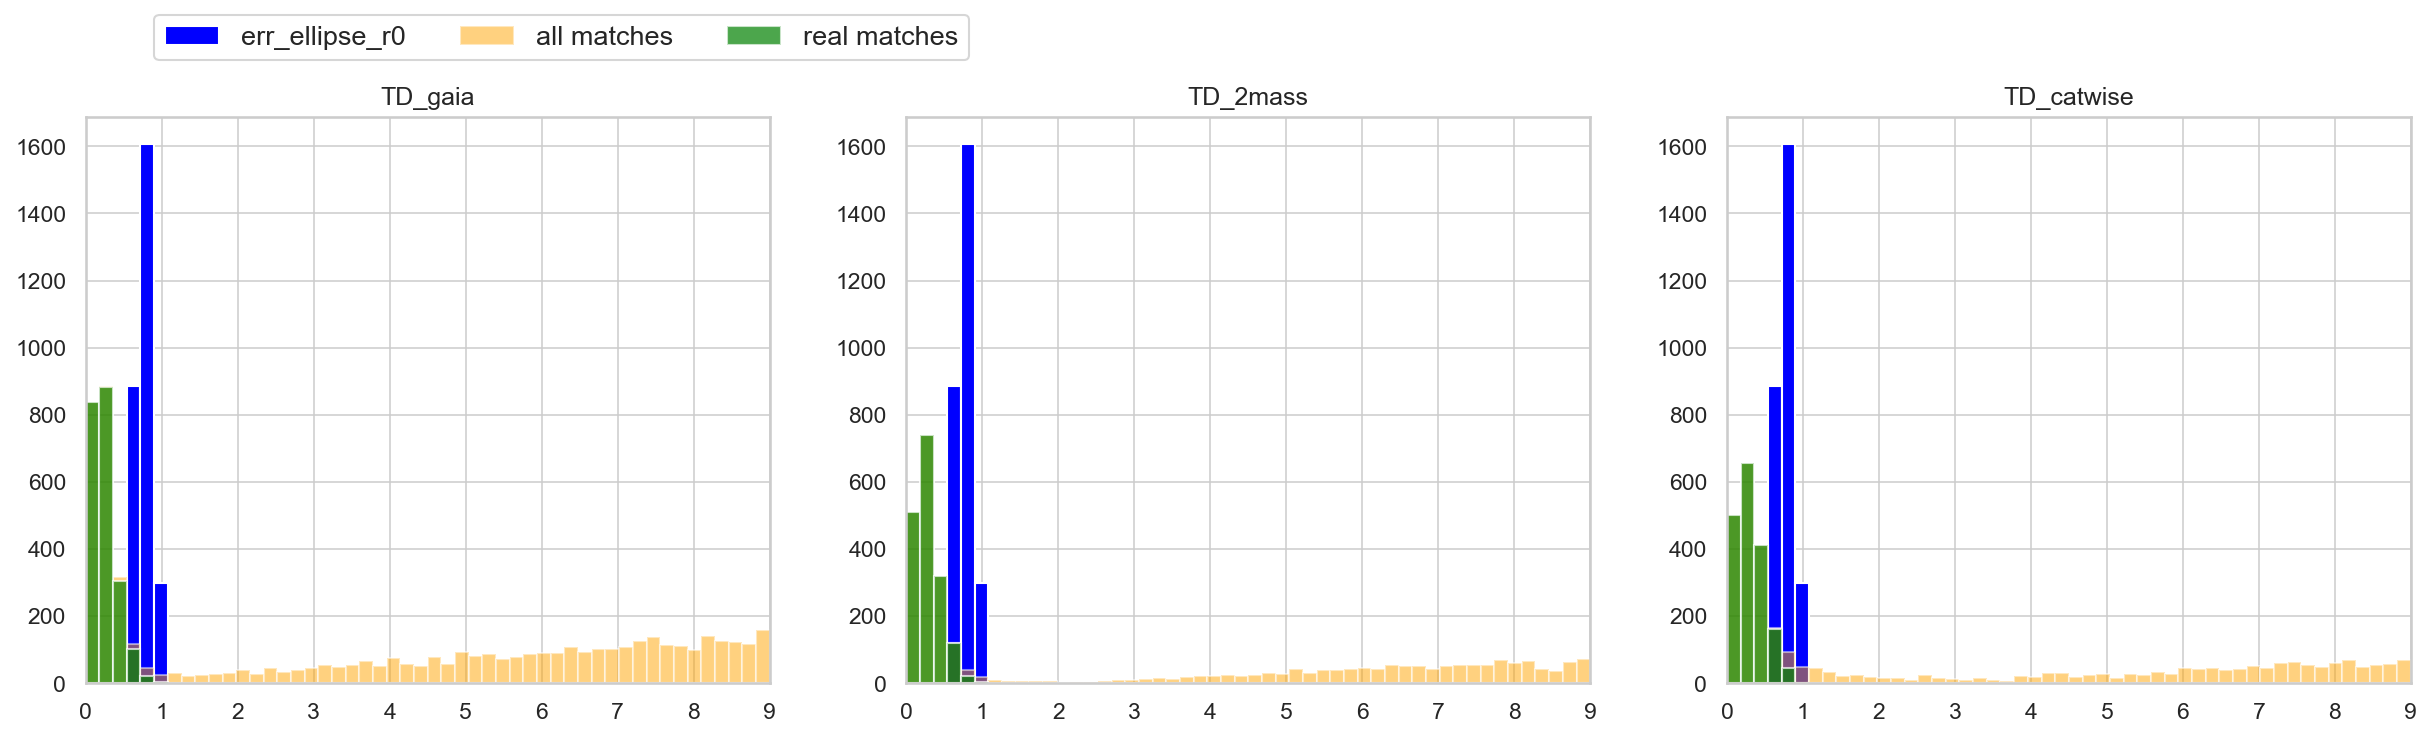

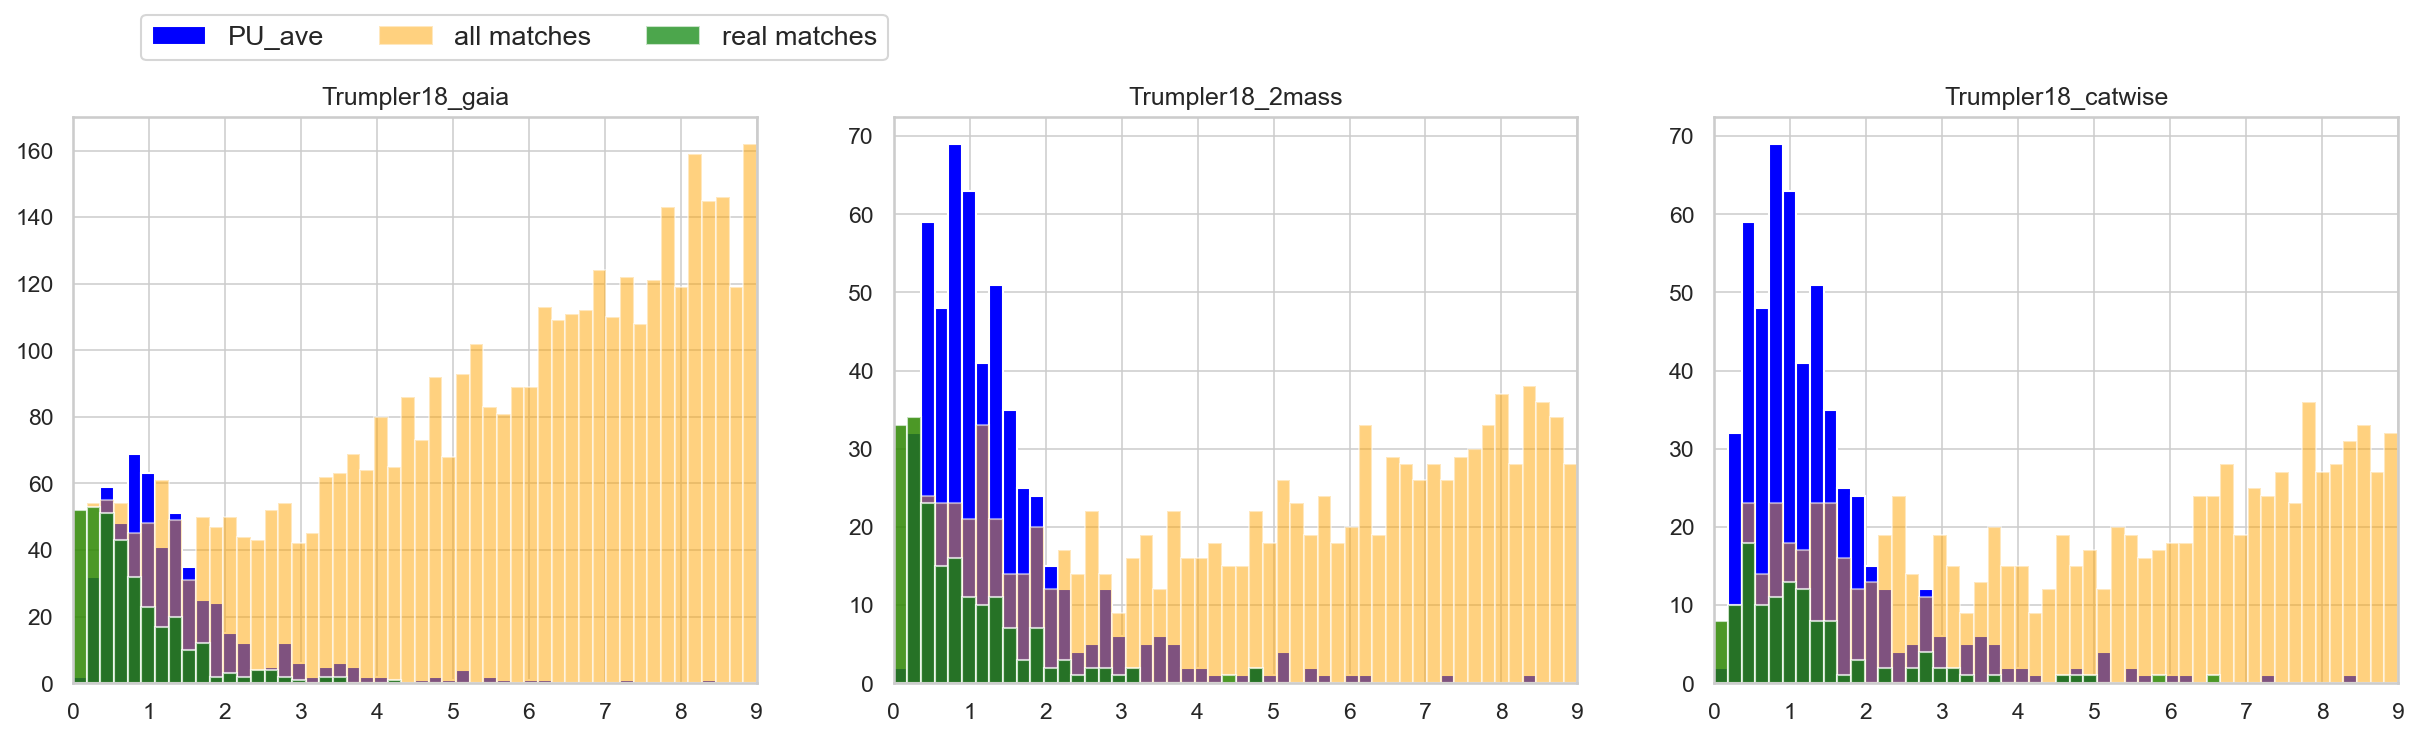

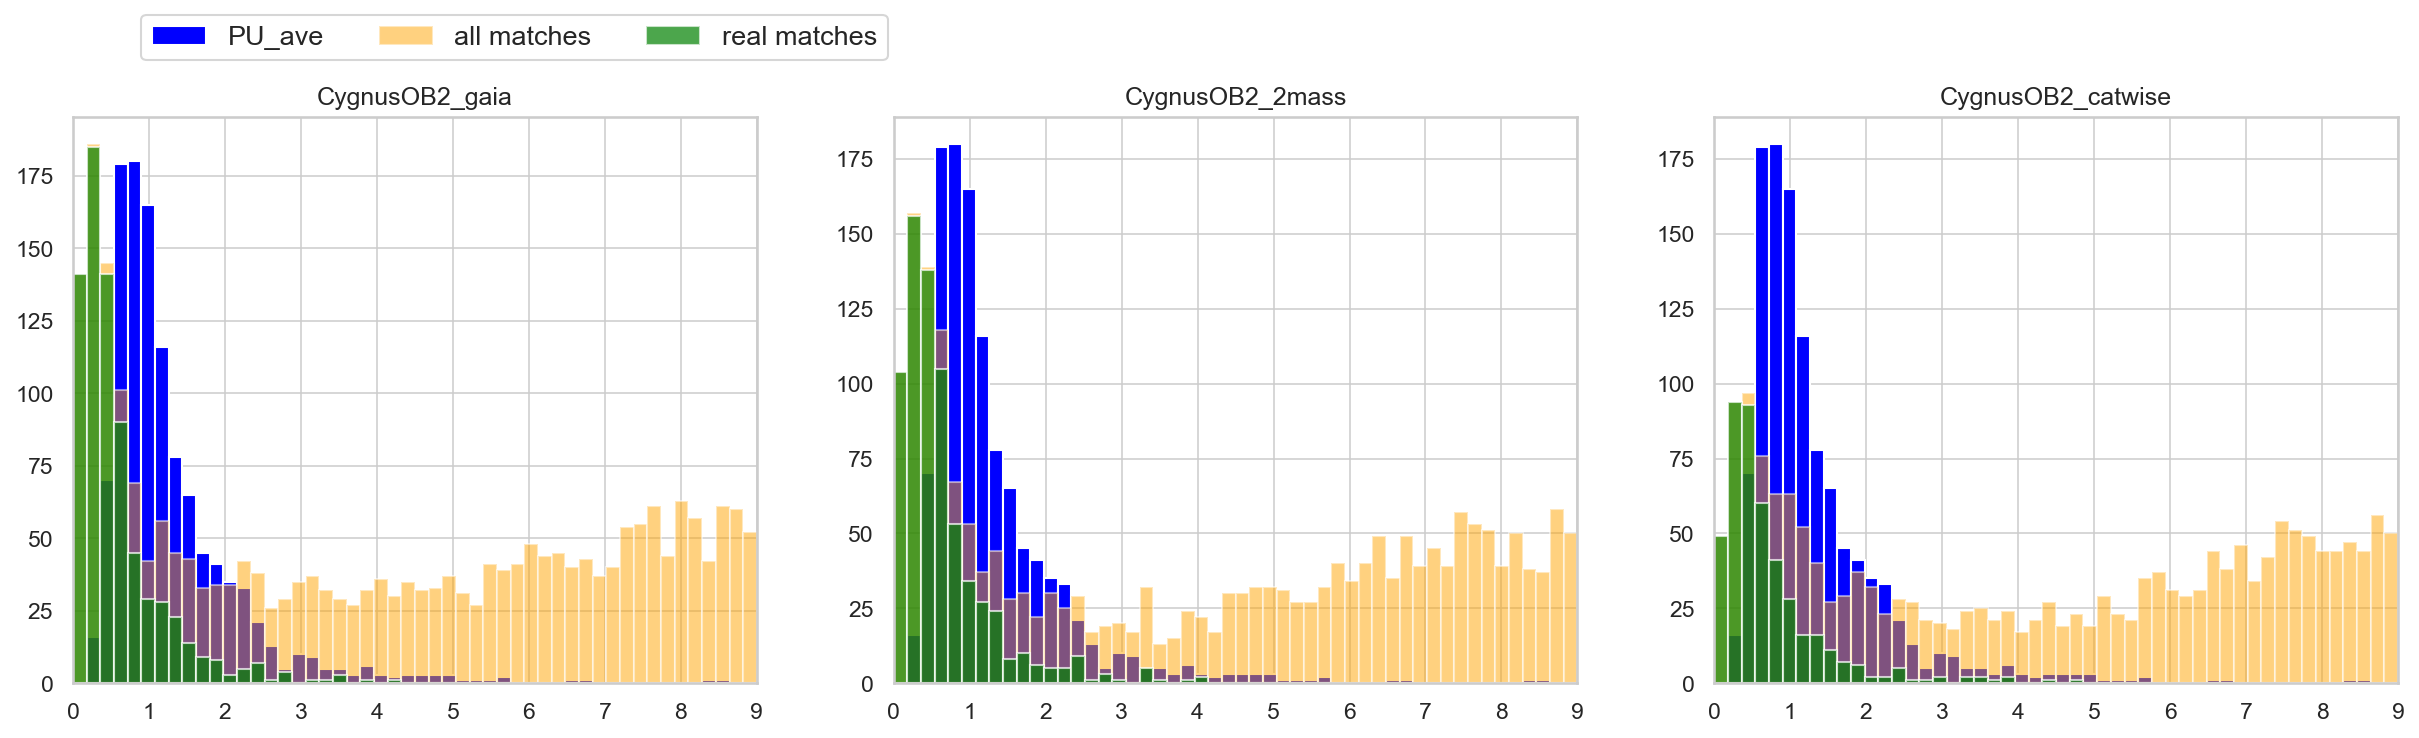

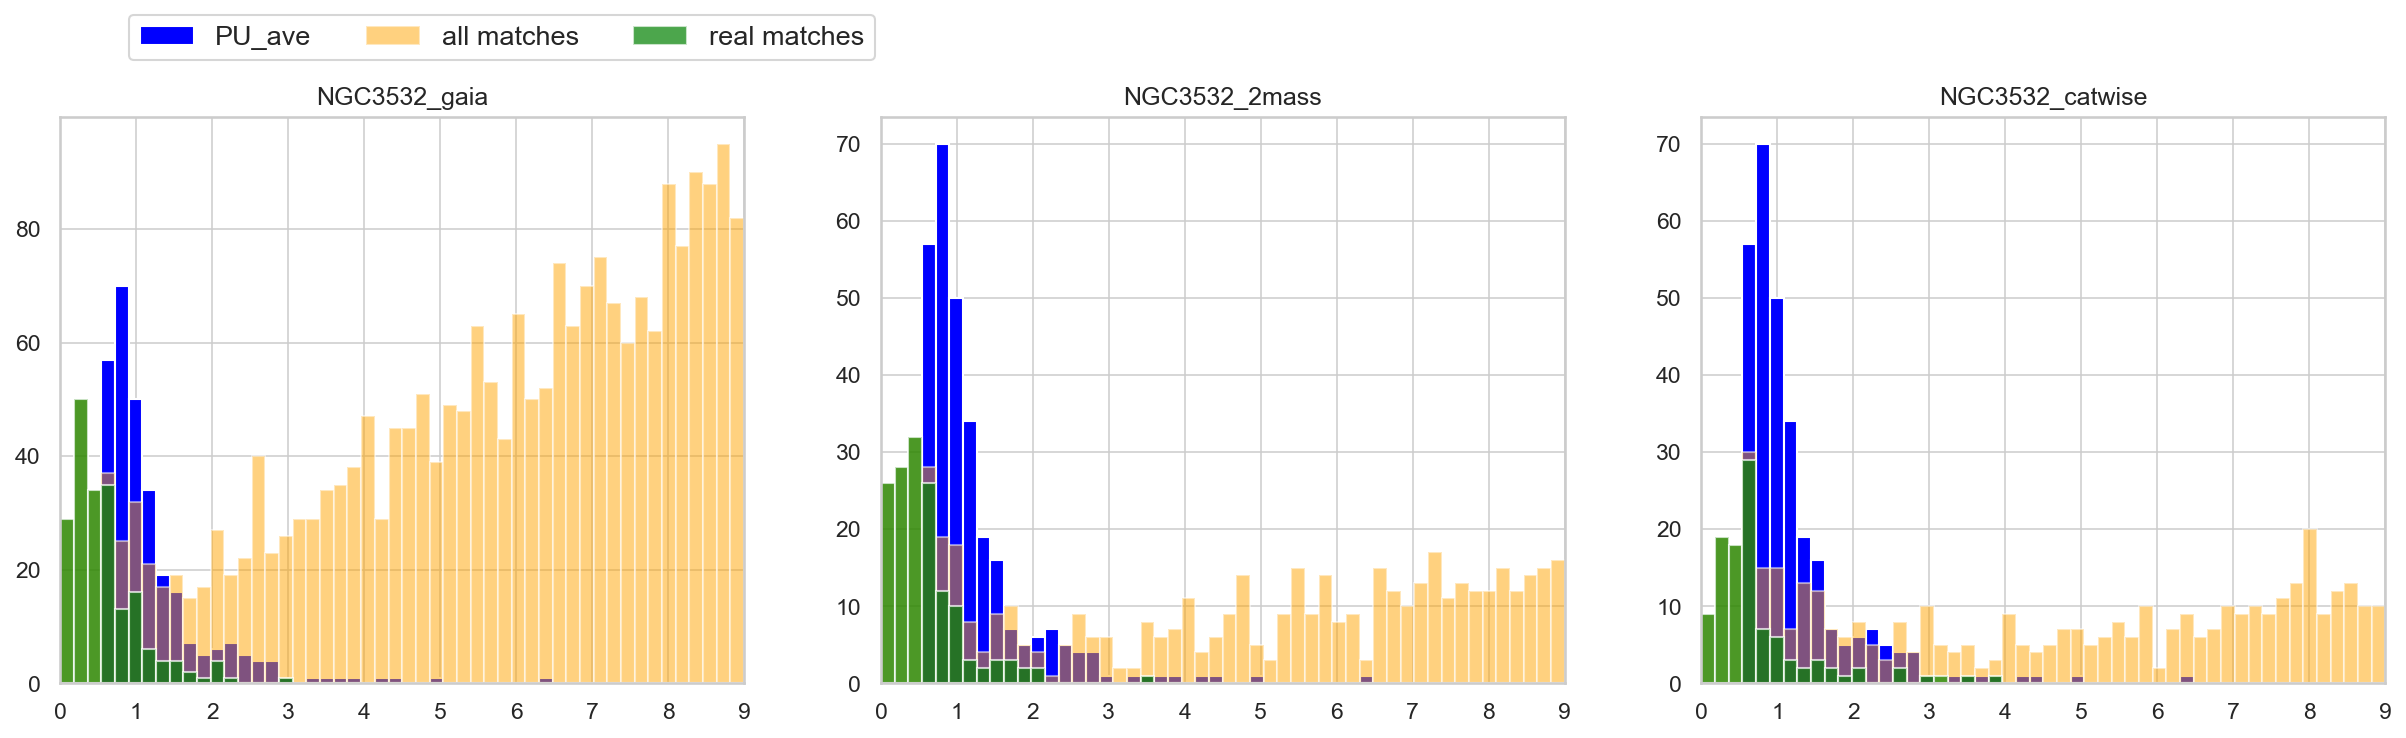

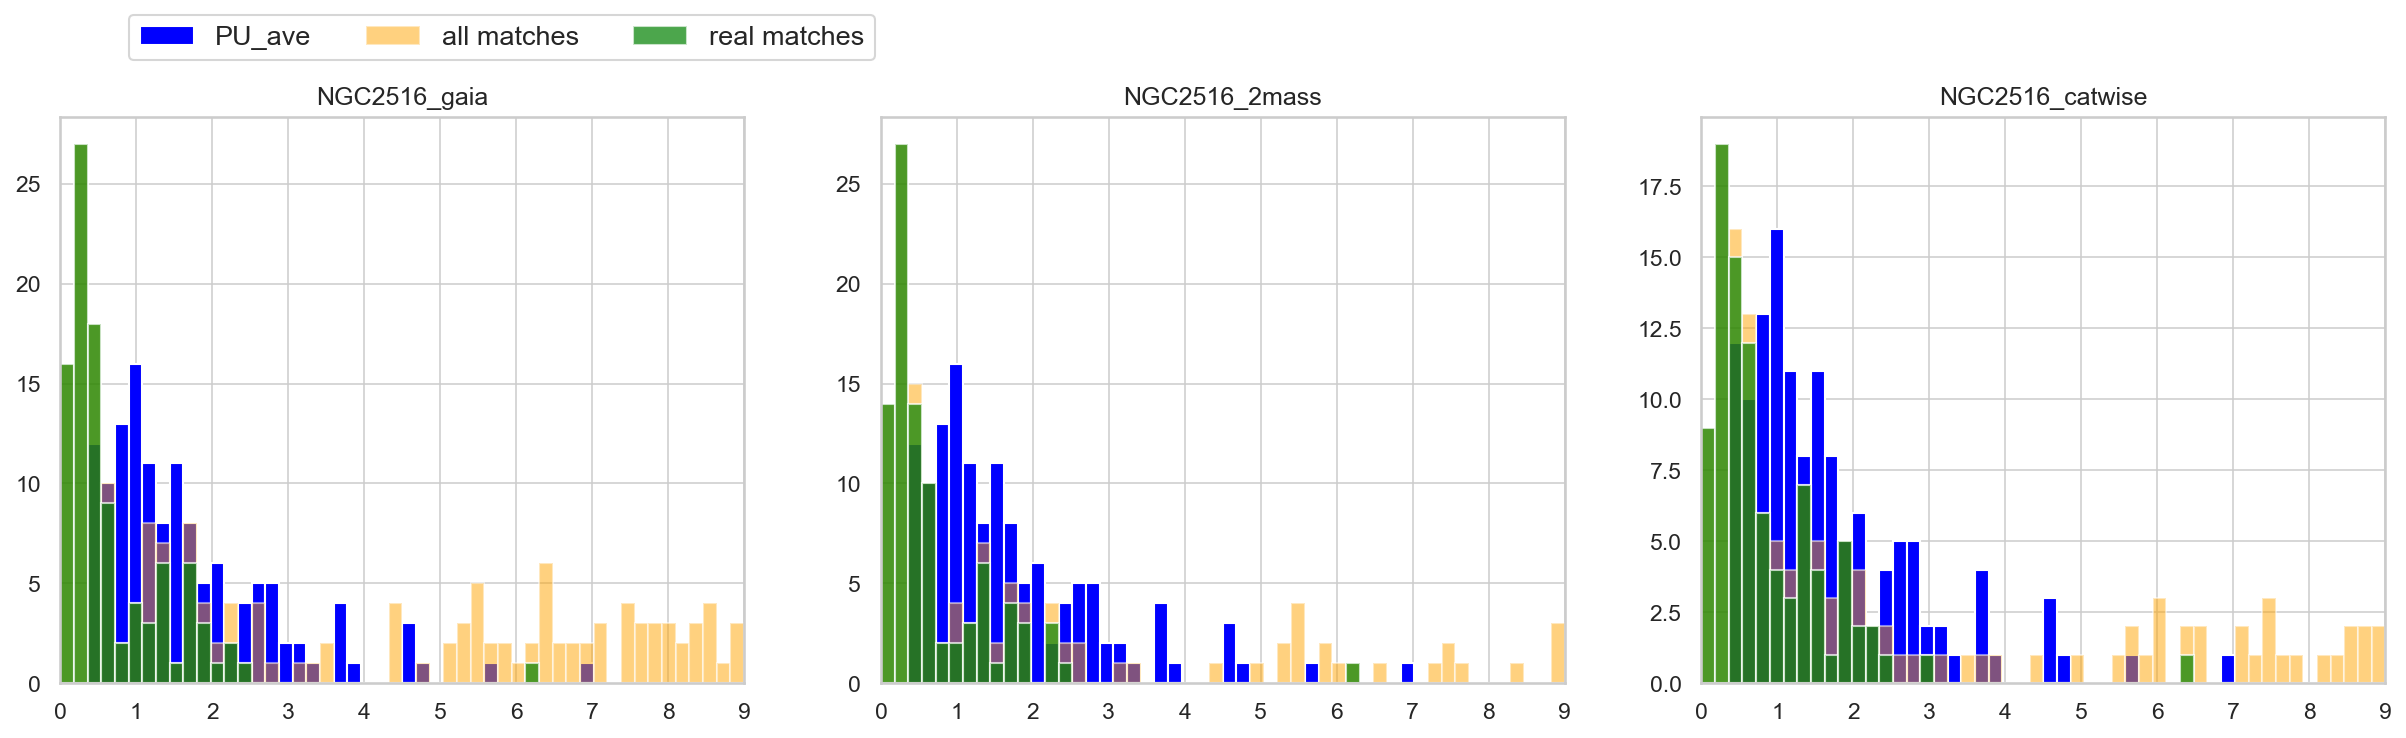

In [3]:
r_max = 9

TD = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/TD/versions/CSC_TD_v5_MW/CSC_TD_v5_MW_simbad.csv')

Trumpler18 = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/Fields/CXO/Trumpler18/Trumpler18_MW.csv')
CygnusOB2 = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/Fields/CXO/CygnusOB2/CygnusOB2_MW.csv')
NGC3532 = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/Fields/CXO/NGC3532/NGC3532_MW.csv')
NGC2516 = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/Fields/CXO/NGC2516/NGC2516_MW.csv')


df_fields = [TD, Trumpler18, CygnusOB2,NGC3532,NGC2516]
fields = ['TD', 'Trumpler18', 'CygnusOB2','NGC3532','NGC2516']
pus =   ['err_ellipse_r0', 'PU_ave', 'PU_ave','PU_ave', 'PU_ave']


for df, field, pu in zip(df_fields, fields, pus):


    print(field, 'has ', len(df), 'sources.')

    cats = ['_gaia', '_2mass', '_catwise']
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5),)
    n_bins = 50

    for cat, i in zip(cats, range(3)):
        rs = np.array([ np.fromstring(s[1:-1], dtype=np.float, sep=', ') if isinstance(s, str) else np.nan for s in df['_r'+cat]])
        rs = list(flatten(rs))
        rs = [ r if r <r_max else np.nan for r in rs]
        matches = df['angDist'+cat].values
        errs = df[pu].values
        axs[i].hist(errs, n_bins, range=[0,r_max],histtype='bar',  label=pu, color='blue')
        axs[i].hist(rs, n_bins, range=[0,r_max], histtype='bar',  label='all matches', color='orange',alpha = 0.5)
        axs[i].hist(matches, n_bins, range=[0,r_max], histtype='bar', label='real matches', color='green',alpha = 0.7)
        
        axs[i].set_title(field+cat)
        axs[i].set_xlim(xmin=0, xmax = r_max)
    
    axs.flat[0].legend(fontsize=13.,ncol=9, loc=(.1, 1.1))


The figures above show the distributions of 
* in blue histogram: the 2-sigma positional uncertainties (err_ellipse_r0 for TD from CSC 2.0 and self-calculated positional uncertainties (https://cxc.cfa.harvard.edu/csc2/why/err_ellipse_cio.html) from CXO pipeline, labeled as err_ellipse_ro or PU_ave
* in green histogram: the separations of nearest multiwavelength matches within the error circles to the X-ray coordinates, labeled as real matches 
* in orange histogram: the separations of all multiwavelength matches to the X-ray coordinates, labeled as all matches
* for the TD in the 1st row, fields Trumpler 18/CygnusOB2/NGC 3532/NGC 2516 in the following rows
* for gaia edr3, 2mass, catwise2020 catalogs in the 1st/2nd/3rd columns


As you can see from the orange histograms, it peaks around zero and then decreases to a lowest point before rising at larger distances. This makes sense as the peak is caused by the true matches while the rising up is due to the coincident matches goes up quadratically with radius.  
And the lowest points of orange histogram more or less coincide with the peaks of histograms of the positional uncertainties of X-ray sources in blue. 
Besides the matching efficiency is high since the green histogram takes a large fraction of the orange histogram near zero. 

However, there are still some worries that the positional uncertainties might be underestimated since 
* the peaks of positional uncertainties in blue may be systematically smaller than the trough of orange histograms, especially for WISE catalog 
* the histogram of WISE matches for 4 fields shows that the central peak of the all matches in orange deviates from zero which might indicate that the astrometric correction is not appropriately corrected. 

# Chance coincidence probability distributions per class per catalog for TD

4
2
1


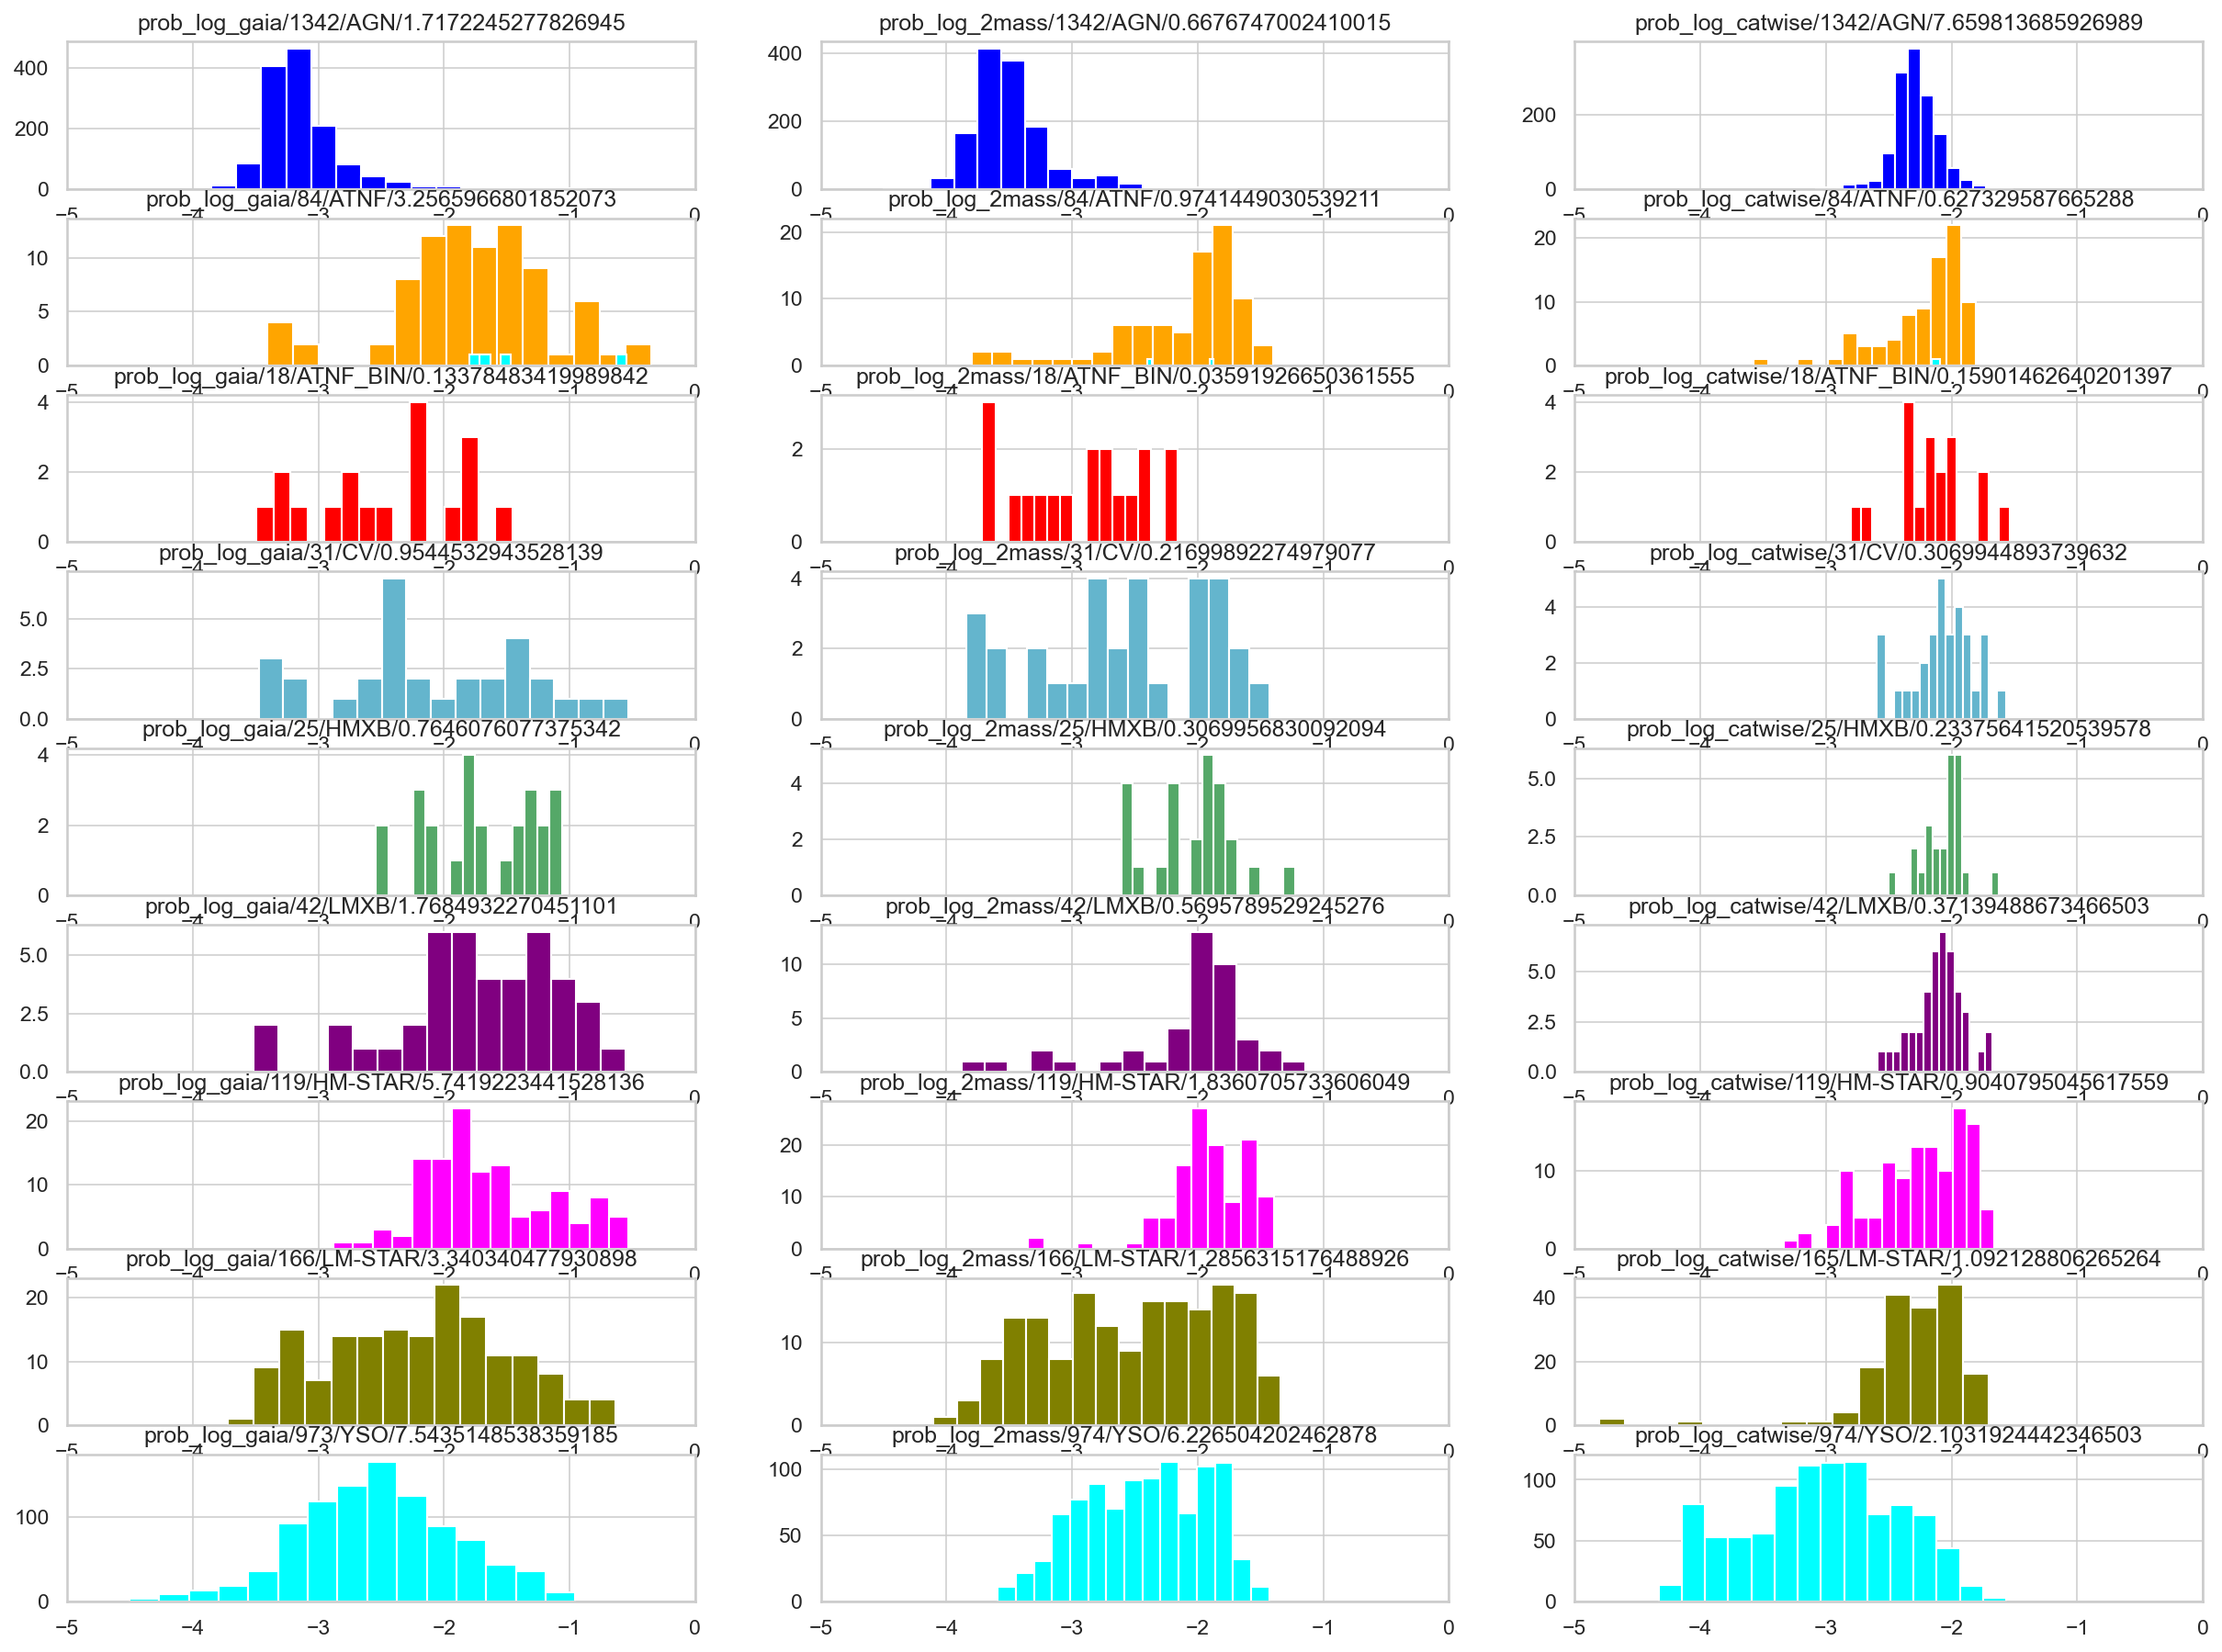

In [4]:
data_dir = "/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/DATA/TD/versions/CSC_TD_v5_MW/"
TD_name = "CSC_TD_v5_MW_simbad_Clean.csv"

TD = pd.read_csv(data_dir+TD_name)

TD = TD.fillna(exnum)
features = ['prob_log_gaia', 'prob_log_2mass', 'prob_log_catwise']
mags = ['Gmag', 'Jmag', 'W1mag_catwise']
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(20, 15),)
n_bins = 15
for i, fea, mag in zip(range(len(features)), features, mags):
    

        for Class, j, color in zip(class_names, range(9), class_colors):
            TD_fea_class = TD.loc[(TD.Class == Class) & (TD[fea]!=exnum), fea]

            titles = fea +'/'+str(len(TD_fea_class))+'/'+Class+'/'+str(np.nansum([ 10**prob for prob in TD_fea_class]))
            axs[j][i].hist(TD_fea_class, n_bins, histtype='bar',  stacked=True, color=color)#,label=label)#, density=True)
            axs[j][i].set_title(titles)
            axs[j][i].set_xlim(xmin=-5, xmax = 0)
            if Class == 'ATNF':
                NS_fea = TD.loc[(TD.Class == Class) & (TD[fea]!=exnum) & (TD[mag]!=exnum), fea]
                print(len(NS_fea))
                axs[j][i].hist(NS_fea, n_bins, histtype='bar',  stacked=True, color='cyan')#,label=label)#, density=True)
                axs[j][i].set_xlim(xmin=-5, xmax = 0)
    

I calculated the chance coincidence probabilities for the sources in the TD per class (in rows) for gaia, 2mass, and wise matches (in columns). 
The name for each histogram includes the parameter being plotted in log10(probability), number of matches, class and the sum of all probabilities from those matches. 

Indeed NS has a relatively large confusion compared to other classes and the real situation for NS is that it has 4/2/1 incident matches for gaia/2mass/wise compared to the estimated values of 3.3/1.0/0.6 from the chance coincidence probabilities calculated here. 

CV, HMXB, LMXB, HM-STAR, LM-STAR have relatively large confusions as well. 

# The leave-one-out evaluation of TD using all features without samplings

v9_combined
Normalized confusion matrix
Normalized confusion matrix
Accuracy: 0.8832559800071403
Accuracy (>70%): 0.969434306569343
Balanced Accuracy: 0.6396477862104496
Balanced Accuracy (>70%): 0.7519476555440163


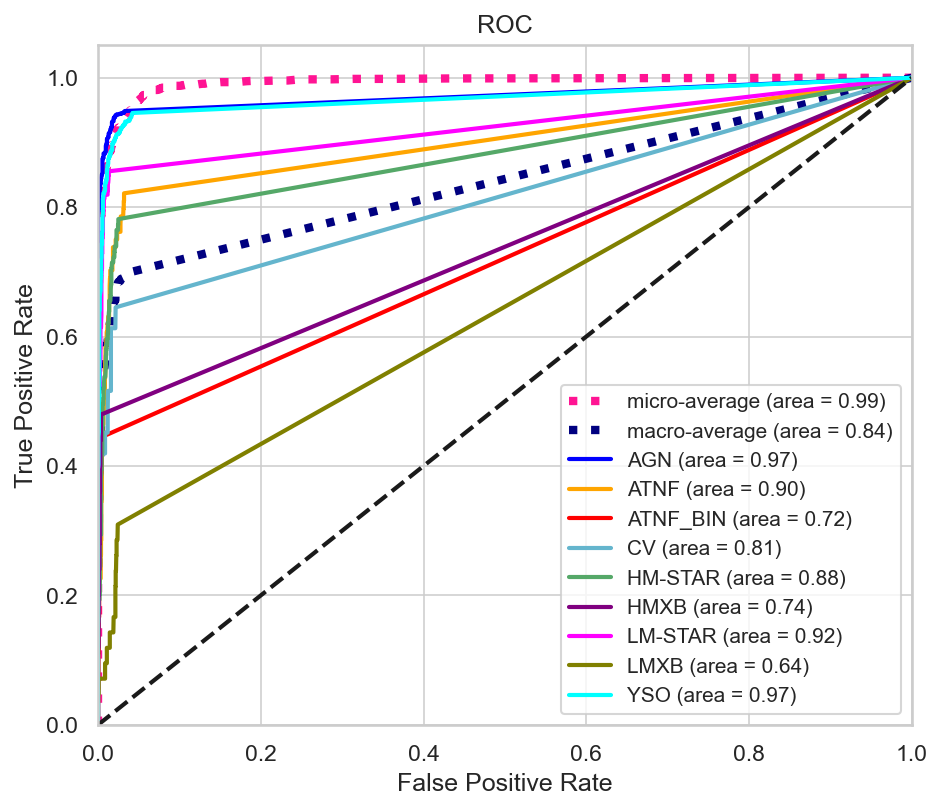

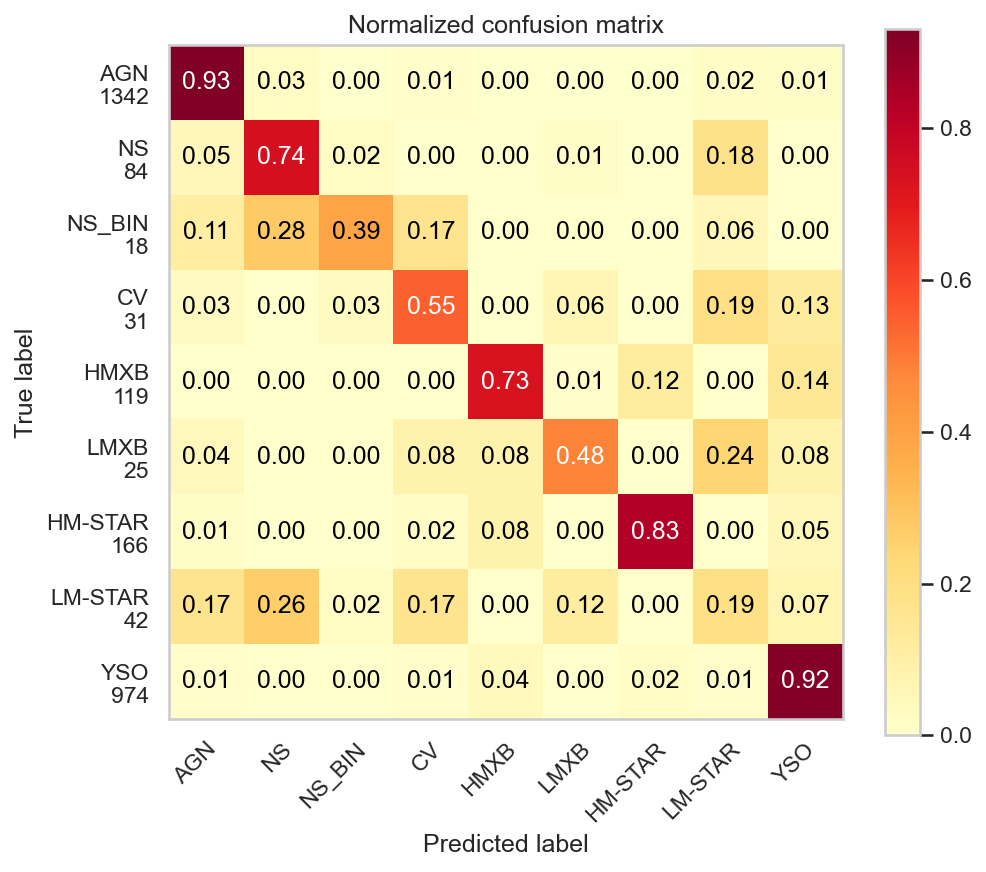

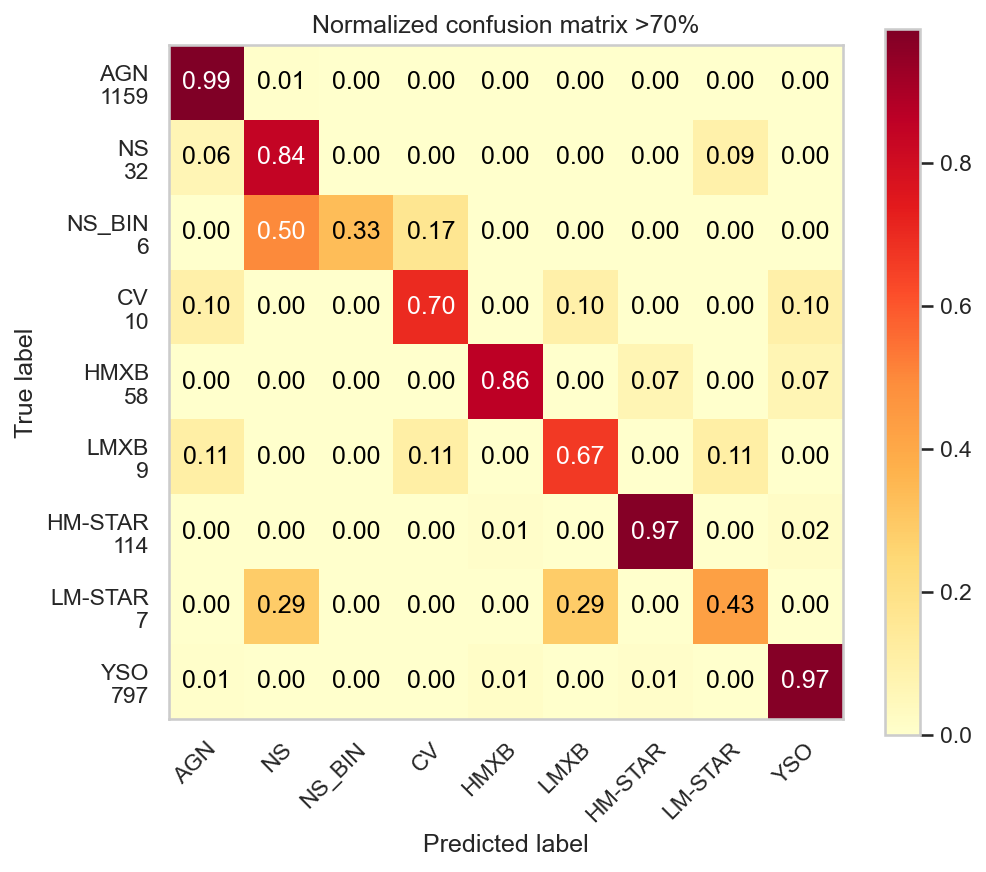

In [5]:


for v in  ['v9_combined']:
    print(str(v))
    
    file = 'LOU_all_CSC_RF_test2_2_'
    v_dir ='../ML_pipeline_v9_test1/data/'+str(v)+'/'
    df = pd.read_csv(v_dir+file+'combined.csv')
    data = df.drop_duplicates(subset=['name'])
    #print(len(data))

    probs = np.array(df.iloc[:,:9]) #np.array([ np.fromstring(s[1:-1], dtype=np.float, sep=', ') for s in data.probs])
    #'''
    fig = plot_newROC(data.true_Class, data.Class, probs,classes=data.columns[:9]) 
    plt.savefig('./data/figs/'+str(v)+'_'+file+'ROC.png')
    #plt.close(fig)
    
    fig = muwclass.plots.plot_confusion_matrix(data.true_Class, data.Class, classes=data.columns[:9], normalize=True, title='Normalized confusion matrix',cmap=plt.get_cmap('YlOrRd'))
    plt.savefig('./data/figs/'+str(v)+'_'+file+'CM.png')
    #plt.close(fig)
    #'''
    where_70 = np.where(np.amax(probs,axis =1) >=0.7)[0]
    #print(where_70)
    if where_70.any():
        probs_70 = probs[where_70]
        y_true_70 = data.iloc[where_70]['true_Class']# .real_class.values[where_70]
        y_pred_70 = data.iloc[where_70]['Class']

        fig = muwclass.plots.plot_confusion_matrix(y_true_70, y_pred_70, classes=data.columns[:9], normalize=True,
                      title='Normalized confusion matrix >70%',cmap=plt.get_cmap('YlOrRd'))
        plt.savefig('./data/figs/'+str(v)+'_'+file+'70_CM.png') 
        #plt.close(fig)
    
    accuracy_noran = accuracy_score(data.true_Class, data.Class)
    accuracy_70_noran = accuracy_score(y_true_70, y_pred_70)
    print('Accuracy:',str(accuracy_noran))
    print('Accuracy (>70%):',str(accuracy_70_noran))
    
    balanced_accuracy_noran = balanced_accuracy_score(data.true_Class, data.Class)
    balanced_accuracy_70_noran = balanced_accuracy_score(y_true_70, y_pred_70)
    print('Balanced Accuracy:',str(balanced_accuracy_noran))
    print('Balanced Accuracy (>70%):',str(balanced_accuracy_70_noran))
    

        

# The leave-one-out evaluation of TD using all features averaged from 10 MCMCs of uncertainties 

V9_test2
Accuracy: 0.8842199214566226 +/- 0.0015318413390164106
Accuracy (>70%): 0.9714787610357627 +/- 0.0021448123199918566
Balanced Accuracy: 0.6485896644822253 +/- 0.009019777220623007
Balanced Accuracy (>70%): 0.740331422045445 +/- 0.022681744712668164


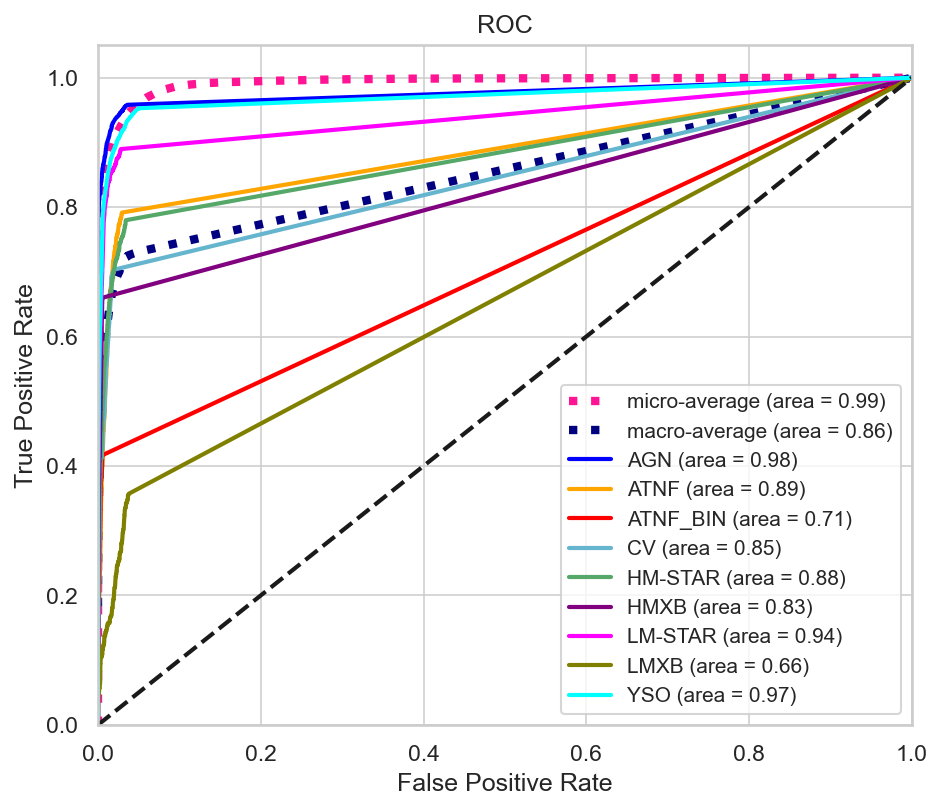

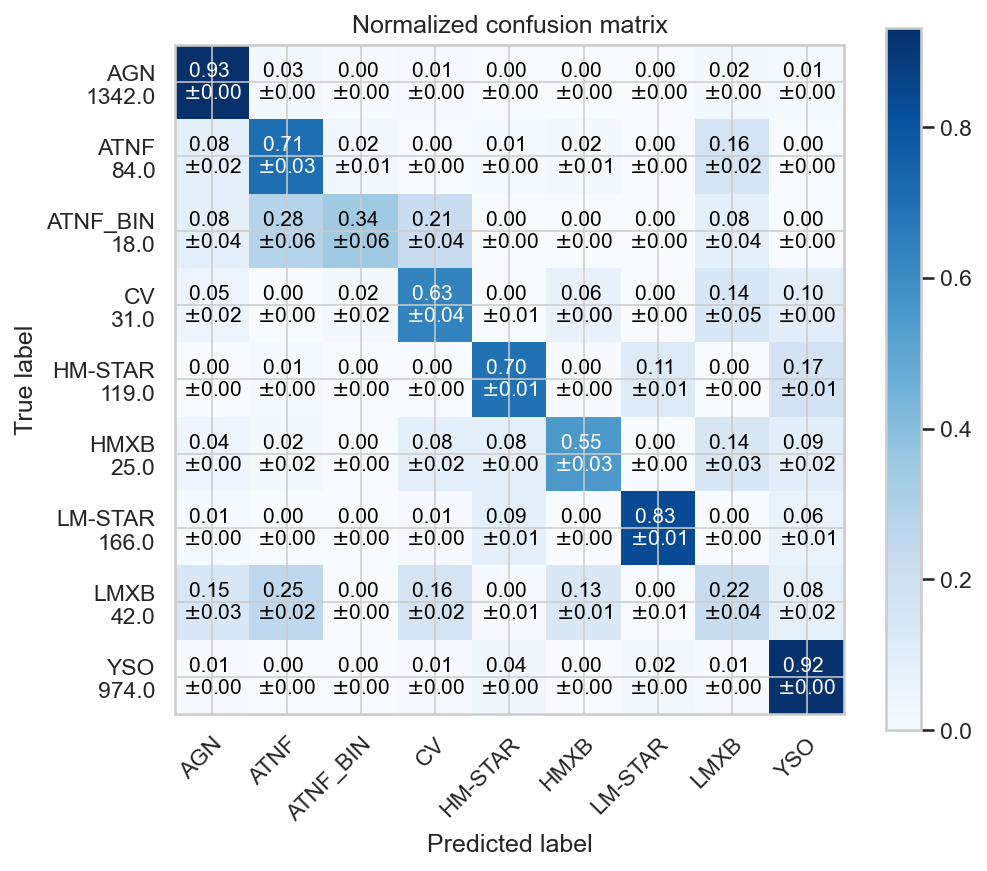

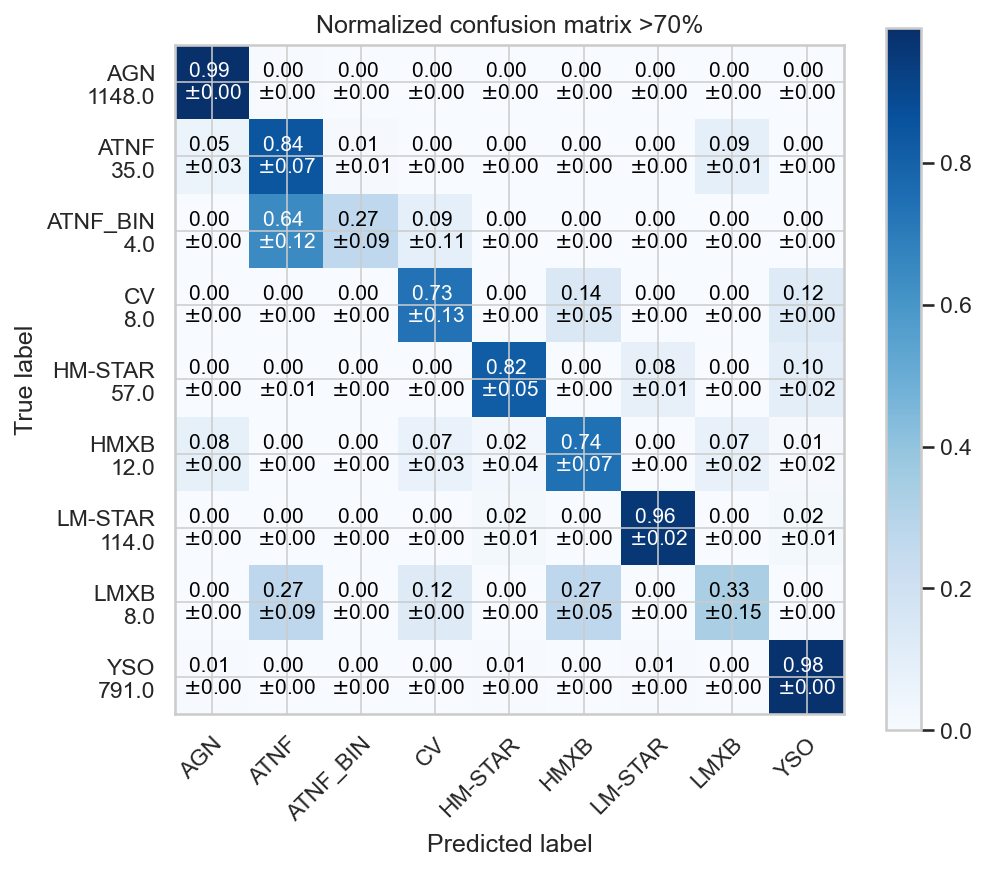

In [6]:

for v,a,b,td in zip( ['9_test2'], [1], [11], ['']):
    print('V'+str(v))
    dfs = []
    confusions = []
    confusions_70 = []

    accuracies = []
    accuracies_70 = []
    balanced_accuracies = []
    balanced_accuracies_70 = []
    #'''
    
    for i in range(a,b):
        #print(i)
        file = 'LOU_all_CSC_RF_Uncer_'+td+str(i)
        v_dir ='../ML_pipeline_v9_test1/data/v'+str(v)+'_combined/'
        data = pd.read_csv(v_dir+file+'_combined.csv')
        #df_sub = df[0:2464]
        #print(len(data))
        #print(str(sorted(Counter(data['real_class']).items())))
        
        probs = np.array(data.iloc[:,:9])
           
        probs_max = np.amax(probs,axis =1)
        #print(probs_max)
        where_70 = np.where(probs_max >=0.7)[0]
        #print(where_70)
        if where_70.any():
            name_70 = data.iloc[where_70]['name']
            probs_70 = probs[where_70]
            probs_max_70 = probs_max[where_70]
            y_true_70 = data.iloc[where_70]['true_Class']# .real_class.values[where_70]
            y_pred_70 = data.iloc[where_70]['Class']

            confusions_70.append(confusion_matrix(y_true_70, y_pred_70, labels=data.columns[:9]))
            accuracies_70.append(accuracy_score(y_true_70, y_pred_70))
            balanced_accuracies_70.append(balanced_accuracy_score(y_true_70, y_pred_70))
        
        #print(confusion_matrix(data.real_class, data.pred, labels=class_names))
        accuracies.append(accuracy_score(data.true_Class, data.Class))
        balanced_accuracies.append(balanced_accuracy_score(data.true_Class, data.Class))
        confusions.append(confusion_matrix(data.true_Class, data.Class, labels=data.columns[:9]))
        dfs.append(data)

        
      
    #'''
    #print(np.average(confusions, axis=0))    
    df_all = pd.concat(dfs)
    probs = np.array(df_all.iloc[:,:9])#np.array([ np.fromstring(s[1:-1], dtype=np.float, sep=', ') for s in df_all.probs])
    #print(probs)
    #print(df_all.real_class[8])
    fig = plot_newROC(df_all.true_Class, df_all.Class, probs,data.columns[:9])
    plt.savefig('./data/figs/v'+str(v)+'_'+td+'ave_ROC_combine.png')
    #plt.close(fig)

    
    fig = plot_CM_withSTD(np.average(confusions, axis=0),np.std(confusions, axis=0),classes=data.columns[:9], normalize=True)
    plt.savefig('./data/figs/v'+str(v)+'_'+td+'ave_CM_combine.png')
    #plt.close(fig)


    fig = plot_CM_withSTD(np.average(confusions_70, axis=0),np.std(confusions_70, axis=0),classes=data.columns[:9], normalize=True, title='Normalized confusion matrix >70%')
    plt.savefig('./data/figs/v'+str(v)+'_'+td+'ave_70CM_combine.png')
    #plt.close(fig)
    
    print('Accuracy:',str(np.mean(accuracies)),'+/-',str(np.std(accuracies)))
    print('Accuracy (>70%):',str(np.mean(accuracies_70)),'+/-',str(np.std(accuracies_70)))
    
    print('Balanced Accuracy:',str(np.mean(balanced_accuracies)),'+/-',str(np.std(balanced_accuracies)))
    print('Balanced Accuracy (>70%):',str(np.mean(balanced_accuracies_70)),'+/-',str(np.std(balanced_accuracies_70)))
    #'''  
    

    

# Feature importances of all possible features 

There are  54  features
['ACIS0512Flux', 'ACIS122Flux', 'ACIS27Flux', 'ACIS057Flux', 'HR_hm', 'HR_ms', 'HR_hms', 'Gmag', 'Bmag', 'Rmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'GB', 'GR', 'GJ', 'GH', 'GK', 'GW1', 'GW2', 'GW3', 'BR', 'BJ', 'BH', 'BK', 'BW1', 'BW2', 'BW3', 'RJ', 'RH', 'RK', 'RW1', 'RW2', 'RW3', 'JH', 'JK', 'JW1', 'JW2', 'JW3', 'HK', 'HW1', 'HW2', 'HW3', 'KW1', 'KW2', 'KW3', 'W1W2', 'W1W3', 'W2W3', 'var_inter_prob', 'var_intra_prob']
There are  31  features selected with thres at 1.0
['ACIS0512Flux' 'ACIS122Flux' 'ACIS27Flux' 'ACIS057Flux' 'HR_hm' 'HR_ms'
 'HR_hms' 'Gmag' 'Bmag' 'Rmag' 'Jmag' 'Hmag' 'Kmag' 'W1mag' 'W2mag'
 'W3mag' 'GB' 'GR' 'GJ' 'GH' 'GK' 'BR' 'RJ' 'JH' 'JK' 'HK' 'W1W2' 'W1W3'
 'W2W3' 'var_inter_prob' 'var_intra_prob']  as Selected features
[0.06216649 0.03807075 0.04413545 0.04854081 0.03188086 0.06393704
 0.04245004 0.03690682 0.02649398 0.03207342 0.02496272 0.02967723
 0.03224491 0.01893936 0.01988889 0.01151369 0.02360027 0.02330755
 0.01

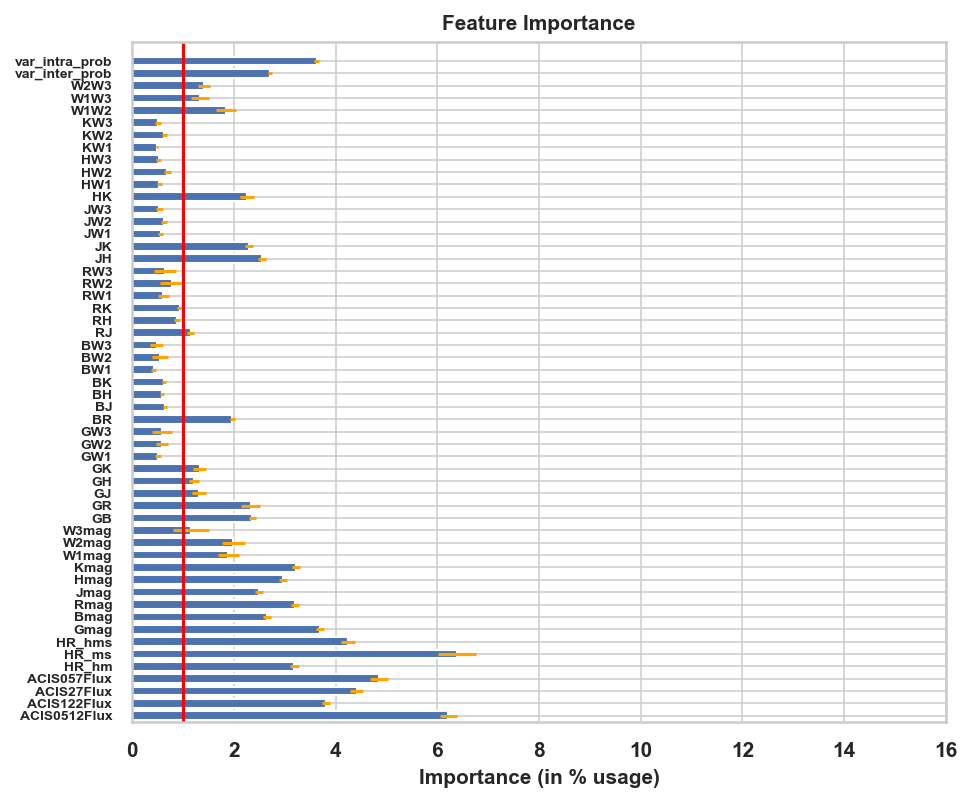

In [7]:
features_all = X_features + MW_features + colors_all + var_features
dfs = []

for v,a,b, feature in zip( ['9'], [2], [3], [ features_all,features_all]):
    
    for i in range(a,b):
    
        file = 'LOU_all_CSC_RF_test2_'+str(i)
        v_dir ='../ML_pipeline_v9_test1/data/v'+str(v)+'_combined/'
        df = pd.read_csv(v_dir+file+'_combined_features.csv')
        #print(df)
        if i==range(a,b)[0]:
            dfs = df
        else:
            dfs = pd.concat([dfs, df])
        #dfs = dfs.append(df)
    #dfs = pd.concat([dfs, df])
    

    importance = dfs.values
    num_feas =  len(feature)
    imps = importance.reshape(int(len(importance)/num_feas),num_feas)
    imps_ave = np.average(imps, axis=0)
    imps_std = np.std(imps, axis=0)
    
    
    #fig = plot_Feature_Importance_withSTD_withnoran(imps_ave, imps_std, imps_noran_ave, imps_noran_std, feature)
    fig = plot_Feature_Importance_withSTD(imps_ave, imps_std, feature)
    plt.savefig('./data/figs/v'+str(v)+'_'+file+'ave_features.png')
    #plt.close(fig)

    



# Leave-one-out evaluation of TD with selected features averaged from 100 MCMCs of uncertainties 

Vv9_test3_combined
Accuracy: 0.8830703320242772 +/- 0.002340823093103214
Accuracy (>70%): 0.9683375018964469 +/- 0.002135614815382518
Balanced Accuracy: 0.6435622727702868 +/- 0.012117427316659555
Balanced Accuracy (>70%): 0.7412572444470094 +/- 0.017858779638430678


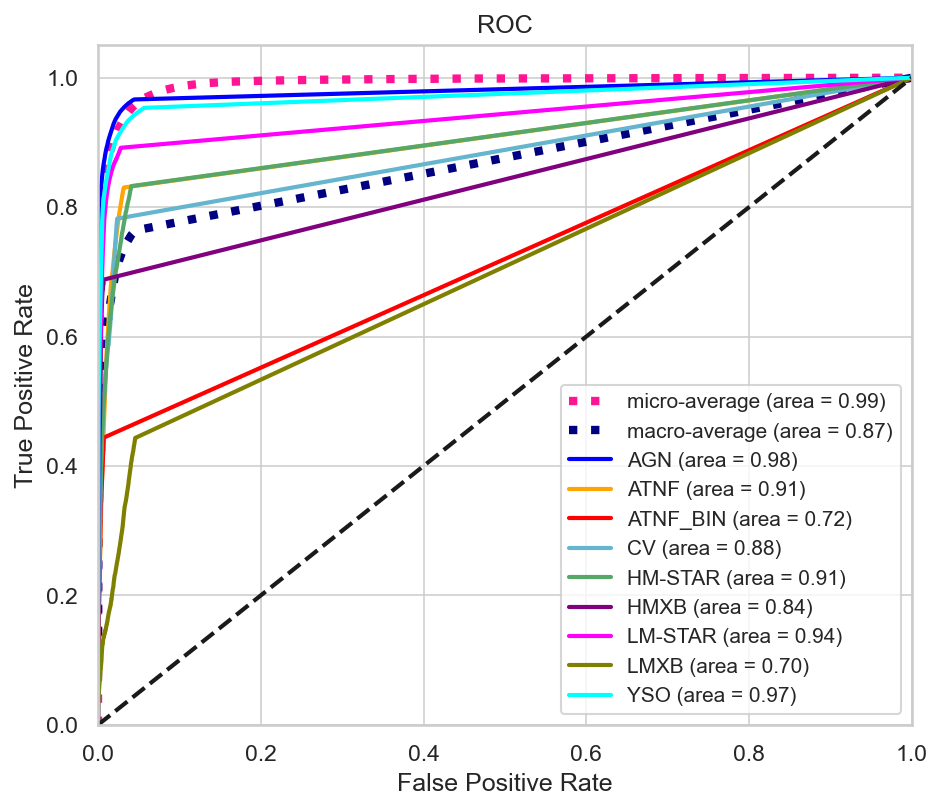

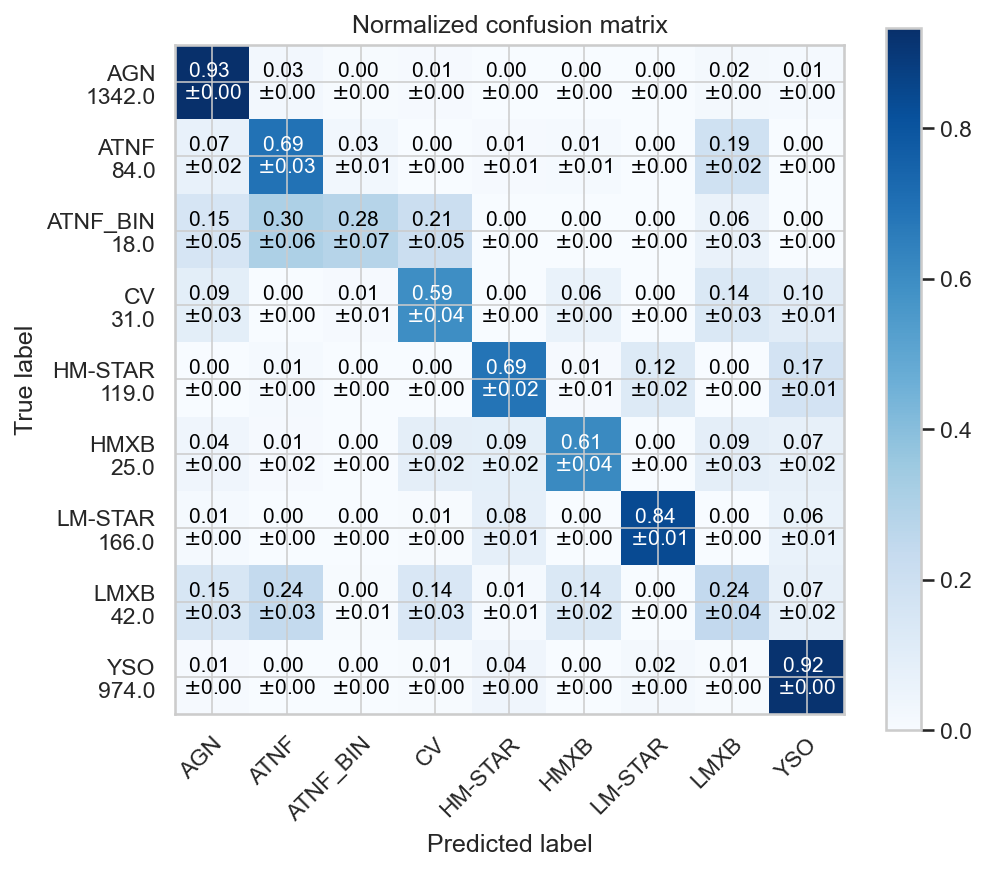

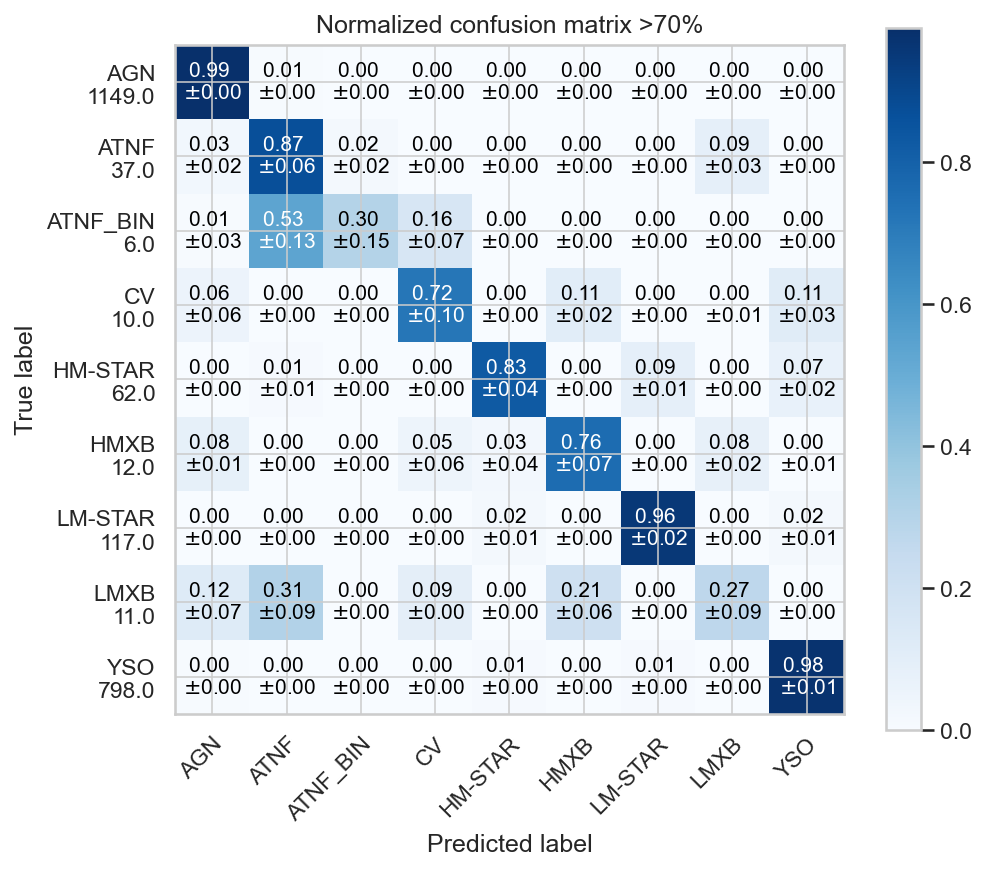

In [8]:

for v,a,b,td  in zip( ['v9_test3_combined'], [1], [101], ['']):
    print('V'+str(v))
    dfs = []
    confusions = []
    confusions_70 = []

    accuracies = []
    accuracies_70 = []
    balanced_accuracies = []
    balanced_accuracies_70 = []
    #'''
    
    for i in range(a,b):
        file = 'LOU_all_CSC_RF_Uncer_'+td+str(i)
        v_dir ='./data/'+str(v)+'/'
        data = pd.read_csv(v_dir+file+'_combined.csv')
        
        probs = np.array(data.iloc[:,:9])
        probs_max = np.amax(probs,axis =1)
        where_70 = np.where(probs_max >=0.7)[0]
        if where_70.any():
            name_70 = data.iloc[where_70]['name']
            probs_70 = probs[where_70]
            probs_max_70 = probs_max[where_70]
            y_true_70 = data.iloc[where_70]['true_Class']# .real_class.values[where_70]
            y_pred_70 = data.iloc[where_70]['Class']

            confusions_70.append(confusion_matrix(y_true_70, y_pred_70, labels=data.columns[:9]))
            accuracies_70.append(accuracy_score(y_true_70, y_pred_70))
            balanced_accuracies_70.append(balanced_accuracy_score(y_true_70, y_pred_70))
        
        accuracies.append(accuracy_score(data.true_Class, data.Class))
        balanced_accuracies.append(balanced_accuracy_score(data.true_Class, data.Class))
        confusions.append(confusion_matrix(data.true_Class, data.Class, labels=data.columns[:9]))
        dfs.append(data)

    df_all = pd.concat(dfs)
    probs = np.array(df_all.iloc[:,:9])
    fig = plot_newROC(df_all.true_Class, df_all.Class, probs,data.columns[:9])
    plt.savefig('./data/figs/'+str(v)+'_'+td+'ave_ROC_combine.png')
    #plt.close(fig)
    
    fig = plot_CM_withSTD(np.average(confusions, axis=0),np.std(confusions, axis=0),classes=data.columns[:9], normalize=True)
    plt.savefig('./data/figs/'+str(v)+'_'+td+'ave_CM_combine.png')
    #plt.close(fig)

    fig = plot_CM_withSTD(np.average(confusions_70, axis=0),np.std(confusions_70, axis=0),classes=data.columns[:9], normalize=True, title='Normalized confusion matrix >70%')
    plt.savefig('./data/figs/'+str(v)+'_'+td+'ave_70CM_combine.png')
    #plt.close(fig)
    
    print('Accuracy:',str(np.mean(accuracies)),'+/-',str(np.std(accuracies)))
    print('Accuracy (>70%):',str(np.mean(accuracies_70)),'+/-',str(np.std(accuracies_70)))
    
    print('Balanced Accuracy:',str(np.mean(balanced_accuracies)),'+/-',str(np.std(balanced_accuracies)))
    print('Balanced Accuracy (>70%):',str(np.mean(balanced_accuracies_70)),'+/-',str(np.std(balanced_accuracies_70)))
    
    

# Feature importances of selected features 

There are  31  features
['ACIS0512Flux', 'ACIS122Flux', 'ACIS27Flux', 'ACIS057Flux', 'HR_hm', 'HR_ms', 'HR_hms', 'Gmag', 'Bmag', 'Rmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'GB', 'GR', 'GJ', 'GH', 'GK', 'BR', 'RJ', 'JH', 'JK', 'HK', 'W1W2', 'W1W3', 'W2W3', 'var_inter_prob', 'var_intra_prob']
There are  31  features selected with thres at 1.0
['ACIS0512Flux' 'ACIS122Flux' 'ACIS27Flux' 'ACIS057Flux' 'HR_hm' 'HR_ms'
 'HR_hms' 'Gmag' 'Bmag' 'Rmag' 'Jmag' 'Hmag' 'Kmag' 'W1mag' 'W2mag'
 'W3mag' 'GB' 'GR' 'GJ' 'GH' 'GK' 'BR' 'RJ' 'JH' 'JK' 'HK' 'W1W2' 'W1W3'
 'W2W3' 'var_inter_prob' 'var_intra_prob']  as Selected features
[0.07228301 0.03640505 0.04742996 0.05818913 0.02972333 0.07060453
 0.04461438 0.04478809 0.03024465 0.03791552 0.02768321 0.03712425
 0.04197654 0.02365935 0.02590799 0.01140684 0.02607496 0.02850954
 0.01462328 0.01416231 0.01553786 0.02363371 0.01527193 0.03233692
 0.02671399 0.03161044 0.03213699 0.01622707 0.01627761 0.02717292
 0.03975464]  as Selected f

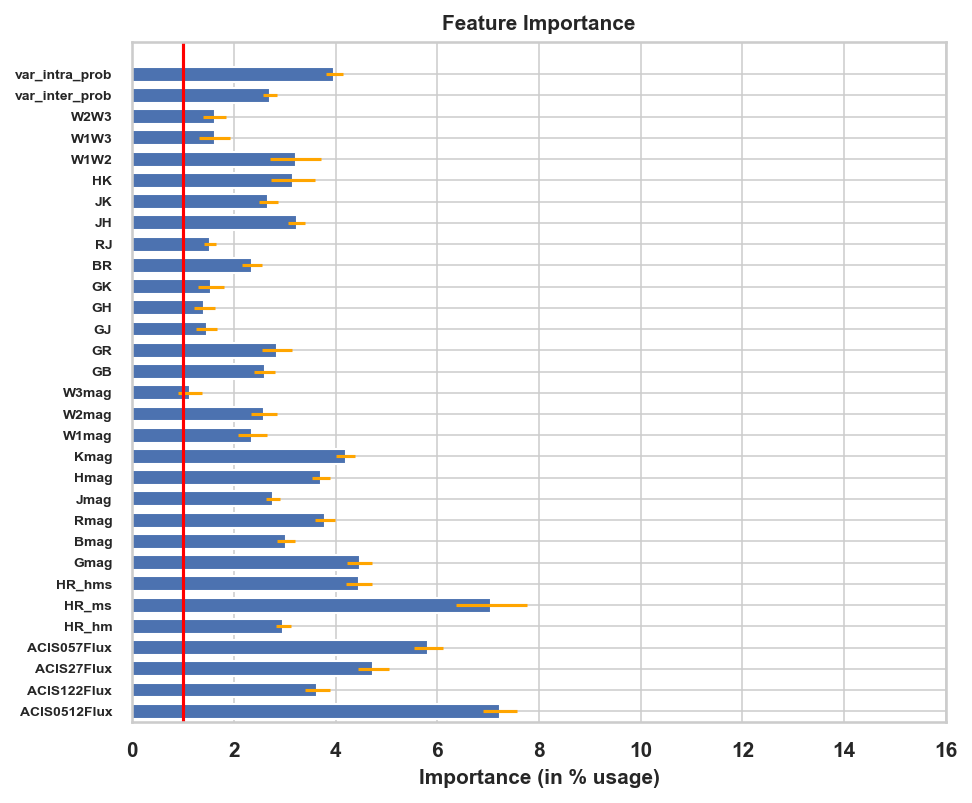

In [9]:
features_all = CSC_features

dfs = []

for v,a,b, feature in zip( ['9_test3'], [1], [101], [features_all,features_all]):
    
    for i in range(a,b):
    
        file = 'LOU_all_CSC_RF_Uncer_'+str(i)
        v_dir ='./data/v'+str(v)+'_combined/'
        df = pd.read_csv(v_dir+file+'_combined_features.csv')
        #print(df)
        if i==range(a,b)[0]:
            dfs = df
        else:
            dfs = pd.concat([dfs, df])
        #dfs = dfs.append(df)
    #dfs = pd.concat([dfs, df])
    

    importance = dfs.values
    num_feas =  len(feature)
    imps = importance.reshape(int(len(importance)/num_feas),num_feas)
    imps_ave = np.average(imps, axis=0)
    imps_std = np.std(imps, axis=0)
    
    
    #fig = plot_Feature_Importance_withSTD_withnoran(imps_ave, imps_std, imps_noran_ave, imps_noran_std, feature)
    fig = plot_Feature_Importance_withSTD(imps_ave, imps_std, feature)
    plt.savefig('./data/figs/v'+str(v)+'_'+file+'ave_features.png')
    #plt.close(fig)

    

